In [1]:
%matplotlib inline

!pip3 install scikit-image

In [4]:
import os
import re
import skimage
import pandas as pd

## Load Files

In [5]:
DATA_FOLDER = os.path.abspath('../data/data1')

In [6]:
file_names = os.listdir(DATA_FOLDER)
img_names= []
for file in file_names:
    if re.match(r'.*[0-9]{6}\.png', file):
        img_names.append(file)

In [7]:
img_names[:5]

['strasbourg_000000_001278.png',
 'strasbourg_000001_054639.png',
 'stuttgart_000016_000019.png',
 'stuttgart_000021_000019.png',
 'strasbourg_000001_003991.png']

In [8]:
PATCH_SIZE = 32
N_IMAGES = 5
N_PATCH_PER_IMAGE = 50

Image to be segmented and predicted segmentation are concated. To predict the predicted segmentation's diff to the ground truth segmentation

In [9]:
def patch(img,x,y):
    return img[y:y+PATCH_SIZE,x:x+PATCH_SIZE]

In [10]:
def load_image_pairs(name):
    img = skimage.io.imread(os.path.join(DATA_FOLDER, name))
    diff = skimage.io.imread(os.path.join(DATA_FOLDER, name[:-4] + '_diff' + name[-4:]))
    seg = skimage.io.imread(os.path.join(DATA_FOLDER, name[:-4] + '_seg' + name[-4:]))
    #gtseg = skimage.io.imread(os.path.join(DATA_FOLDER, name[:-4] + '_train' + name[-4:]))
    
    img = np.asarray(img) / 255
    #gtseg = np.asarray(gtseg) / 255
    seg = np.asarray(seg) / 255
    diff = np.asarray(diff) / 255
    
    return img, diff, seg

In [11]:
x = []
y = []
#for img,seg,gtseg,diff in zip(imgs,segs,gtsegs,diffs):
for name in img_names[:N_IMAGES]:
    print(name)
    img, diff, seg = load_image_pairs(name)
    for _ in range(N_PATCH_PER_IMAGE):
        y_patch = np.random.randint(0,img.shape[0] - PATCH_SIZE+1)
        x_patch = np.random.randint(0,img.shape[1] - PATCH_SIZE+1)
        img_patch = patch(img,x_patch,y_patch)
        seg_patch = patch(seg,x_patch,y_patch)
        diff_patch = patch(skimage.color.rgb2gray(diff),x_patch,y_patch)
        x.append(np.concatenate([img_patch, seg_patch], -1))
        y.append(diff_patch)

strasbourg_000000_001278.png
strasbourg_000001_054639.png
stuttgart_000016_000019.png
stuttgart_000021_000019.png
strasbourg_000001_003991.png


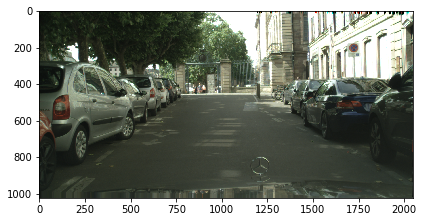

In [12]:
skimage.io.imshow(img)

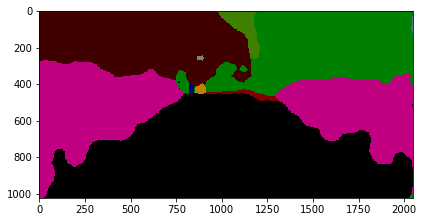

In [13]:
skimage.io.imshow(seg)

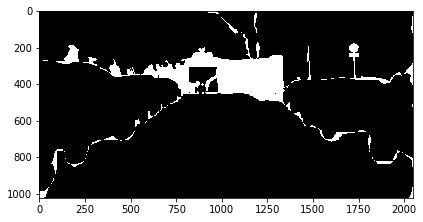

In [14]:
skimage.io.imshow(diff)

In [15]:
del img
del diff
del seg

## Reshape for ANN

In [22]:
x = np.asarray(x)
y = np.asarray(y)

In [23]:
x_tr = np.asarray(x)
y_tr = np.asarray(y)

In [18]:
# 50:50 split
#x_split = int(len(x)/2)
#y_split = int(len(y)/2)
#x_tr = np.asarray(x[:x_split])
#y_tr = np.asarray(y[:y_split])

#x_val = np.asarray(x[x_split:])
#y_val = np.asarray(y[y_split:])

In [24]:
x_tr.shape

(250, 32, 32, 6)

In [25]:
y_tr.shape

(250, 32, 32)

In [26]:
y_tr = y_tr.reshape(-1,PATCH_SIZE**2)
#y_val = y_val.reshape(-1,PATCH_SIZE**2)

## Build and Train Model

In [28]:
def build_model():
    import keras
    from keras.models import Model
    from keras.layers import Input, Dense

    inputs = Input(shape=(PATCH_SIZE,PATCH_SIZE,6))
    x = keras.layers.Conv2D(16,3, activation='relu')(inputs)
    x = keras.layers.Conv2D(16,3, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Flatten()(x)
    x = Dense(PATCH_SIZE**2)(x)
    prediction = x
    model = Model(inputs=inputs, outputs=prediction)
    return model

In [29]:
model = build_model()
model.compile(optimizer='adam',
              loss='mse')
history = model.fit(x=x_tr, y=y_tr,
                    epochs=200)  # starts training

Using TensorFlow backend.


Epoch 1/200
250/250 [==============================] - 4s 16ms/step - loss: 0.2613
Epoch 2/200
250/250 [==============================] - 3s 10ms/step - loss: 0.1140
Epoch 3/200
250/250 [==============================] - 2s 10ms/step - loss: 0.1022
Epoch 4/200
250/250 [==============================] - 3s 10ms/step - loss: 0.0986
Epoch 5/200
250/250 [==============================] - 2s 10ms/step - loss: 0.0942
Epoch 6/200
250/250 [==============================] - 3s 11ms/step - loss: 0.0890
Epoch 7/200
250/250 [==============================] - 3s 11ms/step - loss: 0.0825
Epoch 8/200
250/250 [==============================] - 3s 12ms/step - loss: 0.0800
Epoch 9/200
250/250 [==============================] - 3s 13ms/step - loss: 0.0805
Epoch 10/200
250/250 [==============================] - 3s 13ms/step - loss: 0.0778
Epoch 11/200
250/250 [==============================] - 3s 10ms/step - loss: 0.0694
Epoch 12/200
250/250 [==============================] - 2s 10ms/step - loss: 0.0683
E

250/250 [==============================] - 3s 11ms/step - loss: 0.0084
Epoch 195/200
250/250 [==============================] - 3s 11ms/step - loss: 0.0079
Epoch 196/200
250/250 [==============================] - 3s 14ms/step - loss: 0.0086
Epoch 197/200
250/250 [==============================] - 4s 17ms/step - loss: 0.0064
Epoch 198/200
250/250 [==============================] - 4s 14ms/step - loss: 0.0067
Epoch 199/200
250/250 [==============================] - 2s 10ms/step - loss: 0.0060
Epoch 200/200
250/250 [==============================] - 4s 16ms/step - loss: 0.0071


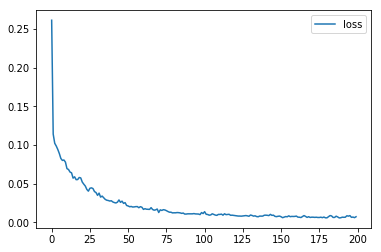

In [30]:
pd.DataFrame(history.history).plot()

## Predict and Plot Validation Images

In [39]:
import matplotlib.pyplot as plt

In [36]:
def pred_image(name):
    img, diff, seg = load_image_pairs(name)
    pred_full = np.zeros(seg.shape[:2] + (1,))
    for i in range(0,img.shape[0],PATCH_SIZE):
        for j in range(0, img.shape[1],PATCH_SIZE):
            y_patch = i
            x_patch = j
            img_patch = patch(img,x_patch,y_patch)
            seg_patch = patch(seg,x_patch,y_patch)
            diff_patch = patch(skimage.color.rgb2gray(diff),x_patch,y_patch)

            x_val = np.concatenate([img_patch, seg_patch], -1)
            x_val.reshape((-1,)+ x_val.shape)
            x_val = np.expand_dims(x_val, 0)
            pred = model.predict(x_val)[0]
            pred_full[i:i+PATCH_SIZE,j:j+PATCH_SIZE] = pred.reshape(PATCH_SIZE,PATCH_SIZE,1)
    return pred_full, img, diff, seg

In [37]:
pred_full, img, diff, seg = pred_image(img_names[42])

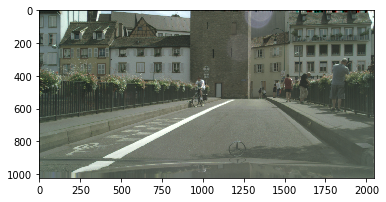

In [40]:
plt.imshow(img)

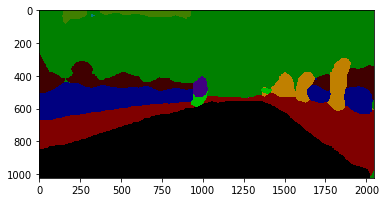

In [41]:
plt.imshow(seg)

In [42]:
plt.imshow(diff)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


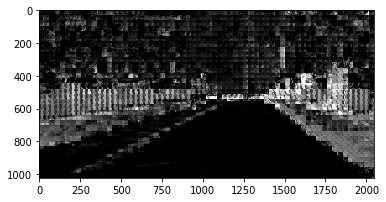

In [43]:
plt.imshow(np.concatenate([pred_full]*3,-1))

In [44]:
pred_full, img, diff, seg = pred_image(img_names[43])

In [45]:
plt.imshow(img)

In [46]:
plt.imshow(seg)

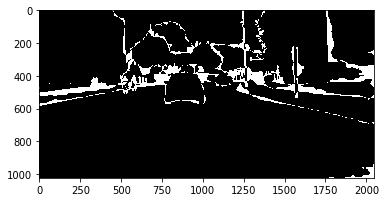

In [47]:
plt.imshow(diff)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


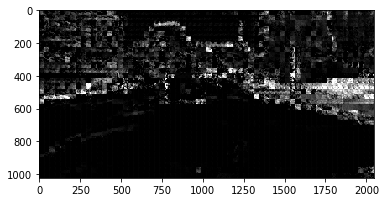

In [48]:
plt.imshow(np.concatenate([pred_full]*3,-1))

### Old Model Plots

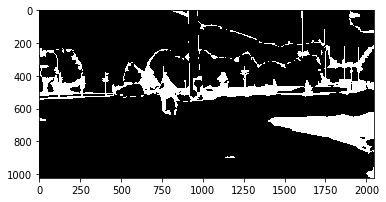

In [79]:
plt.imshow(diff)

In [80]:
plt.imshow(np.concatenate([pred_full]*3,-1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
